In [ ]:
## Attaches burn probabilities to the ZTRAX data
## Uses lat and long provided 
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

In [ ]:
## Get US Map for context and select Western United States
USMAP = gpd.read_file('/data/yoder/DensityProject/cb_2018_us_state_500k.shp')
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']

## Get map(s) of individual states if desired
CO_map = WestStates[WestStates['STUSPS']=='CO']
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

##Convert Coordinate Reference System to US Natinoal Atlas Equal Area
WestStates = WestStates.to_crs("EPSG:2163")

In [ ]:
scratchpath = '/scratch/user/joshua.olsen/20210428_153601/'
os.chdir(scratchpath)
## List all tables included in Zillow Variable names excel file
ZTransLayout = pd.read_excel('Layout.xlsx','ZTrans')
ZTransLayout['TableName'].unique()
ZAsmtLayout = pd.read_excel('Layout.xlsx','ZAsmt')

## Create dataframes from each table name in the Zillow table dictionary
    ## Strip 'ut' from column names
T = {}
for name,group in ZTransLayout.groupby('TableName'):
    T[str(name)[2:]] = group
A = {}
for name, group in ZAsmtLayout.groupby('TableName'):
    A[str(name)[2:]] = group
    
    
## Dictionary of Western 11 states using Zillows numbering: 
states = {'AZ':'04',
          'CA':'06',
          'CO':'08',
          'ID':'16',
          'MT':'30',
          'NV':'32',
          'NM':'35',
          'OR':'41',
          'UT':'49',
          'WA':'53',
          'WY':'56'}

In [ ]:
#Change this value to the state and table you care about
# State to use
state = states['CO']
#Transaction tables to use
Ttables = ['Main', 'PropertyInfo']
# Assessment tables to use
Atables = ['Main','Garage', 'Building']

In [ ]:
## Fields to use from transaction tables
Tfields = {'Main': ['TransId','State','County','DocumentDate','SignatureDate',
                    'RecordingDate','FIPS','DataClassStndCode',
                    'DocumentTypeStndCode','IntraFamilyTransferFlag',
                    'LoanTypeStndCode','PropertyUseStndCode',
                    'SalesPriceAmount', 'LoanAmount'],
            'PropertyInfo':['TransId','ImportParcelID','AssessorParcelNumber',
                            'PropertyFullStreetAddress','PropertyCity',
                            'PropertyState','PropertyAddressLatitude',
                            'PropertyAddressLongitude']}
# Fields to use from Assessment tables
Afields = {'Main': ['RowID','ImportParcelID','LotSizeSquareFeet'],
          'Garage':['RowID','GarageStndCode','GarageAreaSqFt'],
          'Building' :['RowID','ArchitecturalStyleStndCode','BuildingClassStndCode','BuildingQualityStndCode',
                       'BuildingConditionStndCode','EffectiveYearBuilt','YearBuilt','YearRemodeled',
                       'NoOfStories','TotalRooms','TotalBedrooms','TotalKitchens',
                       'FullBath','ThreeQuarterBath','HalfBath','QuarterBath','TotalActualBathCount',
                       'TotalBathPlumbingFixtures','RoofCoverStndCode', 'RoofStructureTypeStndCode',
                       'HeatingTypeorSystemStndCode','AirConditioningTypeorSystemStndCode',
                       'FoundationTypeStndCode','ElevatorStndCode','FireplaceFlag','FireplaceTypeStndCode',
                       'FireplaceNumber','WaterStndCode','SewerStndCode','TimeshareStndCode',
                      'StoryTypeCode']}

In [ ]:
%%time
## Load Ztrans data into dictionary of table entries that will be merged
dfs = {}
keys = Ttables
for i in keys:
    # Populate dictionary with desired tables for the given state
    dfs[i] = pd.read_csv(f'{state}/ZTrans\{i}.txt',sep = '|', header=None,names=T[i]['FieldName'].tolist(), encoding='latin1',usecols=Tfields[i]) 

In [ ]:
%%time
## Load Assessor data

dfA = {}
keys = Atables
for j in keys:
    dfA[j] = pd.read_csv(f'{state}/ZAsmt\{j}.txt',sep='|', header=None,names=A[j]['FieldName'].tolist(),encoding='latin1',usecols=Afields[j])

In [855]:
## Merge Trans tables and Asmt tables
from functools import reduce
Trans = reduce(lambda left,right: pd.merge(left,right,on='TransId',how='left'),dfs.values())
Asmt = reduce(lambda left, right:pd.merge(left,right,on='RowID',how='left'),dfA.values())
df = pd.merge(Trans,Asmt,on='ImportParcelID',how='left')

In [856]:
## Select only valid transactions
UnwantedLoanCodes =  ['AC','CT','CM','CS','CC','CL','DP','FO','FE','HE','LC','EB','EX','MD','NA','NP','FA','RE','RM','SM','SE','TR']
WantedLoanCodes =  ['AS','BL','CE','FM','PM','RD','SL']
DocumentTypeStndCodeDrop= ['CRDE','JTDE','QCDE','RRDE','VLDE']
DocumentTypeStndCodeKeep= ['CPDE','IDDE','PRDE','WRDE']

df = df.loc[(df['SalesPriceAmount'] > 0) &
            (~df['LoanTypeStndCode'].isin(UnwantedLoanCodes)) &
            (pd.isnull(df['IntraFamilyTransferFlag'])) &
            (df['PropertyUseStndCode']=='SR') &
            (df['DocumentTypeStndCode'].isin(DocumentTypeStndCodeKeep)) & 
            (df['TotalBedrooms'] >=1)].copy()

In [857]:
## Make geodataframe

CO = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.PropertyAddressLongitude, df.PropertyAddressLatitude))

In [861]:
CO_proj = CO.copy()
CO_proj.crs="epsg:4326"
CO_proj=CO_proj.to_crs("EPSG:2163")
CO_proj.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [864]:
import rasterio
from rasterstats import zonal_stats, point_query
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [865]:
dst_crs ="EPSG:2163"

In [866]:
with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
                   reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [867]:
src = rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

/home/joshua.olsen/.conda/envs/testenv/lib/python3.8/site-packages/matplotlib/image.py:490: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


<AxesSubplot:>

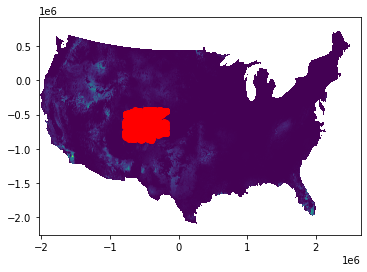

In [868]:
fig, ax = plt.subplots()
show(src,ax = ax)
CO_proj.plot(ax=ax, color ='red')

In [869]:
pts = CO_proj.copy()

In [870]:
CO_proj.shape

(1375077, 41)

In [871]:
## Select only valid geometry (note .isna() does not appear to catch point (nan,nan))
CO_pts = CO_proj[CO_proj['geometry'].is_valid]

In [872]:
CO_pts.shape

(1374190, 41)

In [873]:
# pts = CO_pts.head(100000).copy()
pts = CO_pts.copy()

In [874]:
%%time
pts['BP'] = point_query(pts, '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

CPU times: user 47min 4s, sys: 2min 44s, total: 49min 49s
Wall time: 50min 10s


In [875]:
%%time
## Add burn probability out to 1600 meters
pts['point_geometry'] = pts['geometry'].copy()
pts['geometry'] = pts.buffer(1600)
buff = pd.DataFrame(zonal_stats(pts, 
                             '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif',
                            stats=['max','mean']))
buff.columns = [f'BP1600_'+str(col) for col in buff.columns]

buff.reset_index(drop=True,inplace=True)
pts.reset_index(drop=True,inplace=True)
pts = pd.concat([pts,buff],axis=1)
pts['geometry'] = pts['point_geometry'].copy()

CPU times: user 1h 6min 36s, sys: 4min 44s, total: 1h 11min 21s
Wall time: 1h 11min 29s


In [876]:
BurnCols = ['BP','BP1600_max','BP1600_mean']

<AxesSubplot:>

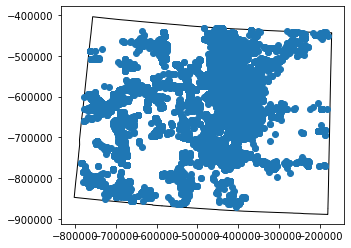

In [881]:
basemap = CO_map.plot(edgecolor='black',color='white')
pts.plot(ax= basemap)

In [989]:
## Create a copy of everything to merge with fires
## For Colorado base memory usage is 471mb with 1,374,190 rows
ST_points = pts.copy()

In [992]:
## Add fire perimeter data
import geopandas as gpd
Fireperims = gpd.read_file('/data/yoder/DensityProject/mtbs_perimeter_data/mtbs_perims_DD.shp')
Fireperims = Fireperims.to_crs("EPSG:2163")

In [993]:
CO_map = CO_map[['STUSPS', 'geometry']]
Buffed_state = CO_map.copy()
Buffed_state['geometry'] = Buffed_state.buffer(100000)
ST_fires = gpd.sjoin(Fireperims, Buffed_state, op='within')
ST_fires = ST_fires.drop(['index_right'], axis=1)
ST_fires['Buffed_geometry100km'] = ST_fires.buffer(100000)
ST_fires['MTBS_geometry'] = ST_fires['geometry'].copy()
ST_fires['geometry'] = ST_fires['Buffed_geometry100km'].copy()

In [953]:
# ST_samp = pts.sample(n=10000)

<AxesSubplot:>

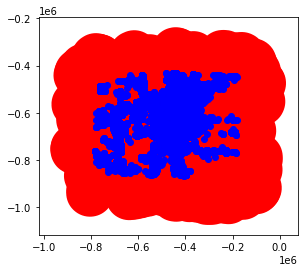

In [999]:
basemap = CO_map.plot(edgecolor='black',color='white')
ST_fires.plot(ax=basemap, color='red')
ST_points.plot(ax= basemap, color='blue')

In [1000]:
%%time
ST_Samp_with_Fires = gpd.sjoin(ST_points, ST_fires, how='left')

CPU times: user 12min 36s, sys: 2min 11s, total: 14min 47s
Wall time: 14min 49s


In [1004]:
def get_distance(row):
    distance = row.geometry.distance(row.MTBS_geometry)
    return distance

In [1005]:
%%time
ST_Samp_with_Fires['Distance'] = ST_Samp_with_Fires.apply(lambda row: get_distance(row),axis=1)

CPU times: user 46min 16s, sys: 2min 21s, total: 48min 38s
Wall time: 48min 41s


In [1008]:
# ST_Samp_with_Fires['Distance'].describe()

count    4.165432e+07
mean     5.771893e+04
std      2.474532e+04
min      0.000000e+00
25%      3.853344e+04
50%      5.665875e+04
75%      7.880748e+04
max      9.999962e+04
Name: Distance, dtype: float64

In [1011]:
pd.options.display.float_format = '{:.2f}'.format

In [1012]:
ST_Samp_with_Fires.describe()

,TransId,FIPS,SalesPriceAmount,LoanAmount,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,LotSizeSquareFeet,GarageAreaSqFt,YearBuilt,YearRemodeled,NoOfStories,TotalRooms,TotalBedrooms,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,FireplaceNumber,BP,BP1600_max,BP1600_mean,index_right,Year,StartMonth,StartDay,Acres,Distance
count,41654318.00,41654318.00,41654318.00,41652390.00,41654318.00,41654318.00,41654318.00,40064593.00,18684898.00,41652927.00,9494845.00,32972734.00,41653877.00,41654318.00,58438.00,32907889.00,58605.00,32966494.00,58605.00,8746365.00,20088195.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00
mean,140586932.49,8043.70,238846.47,190861.33,39.46,-105.12,24226481.35,457227.97,617.43,1973.17,1994.30,1.41,4.99,3.21,1.05,2.16,0.00,0.25,0.00,2.48,1.31,0.00,0.00,0.00,5172.93,2004.05,5.87,15.49,9755.20,57718.93
std,100709466.45,29.53,387903.91,1885459.66,0.57,0.84,14214093.91,11127047.50,848.54,26.09,21.17,0.56,3.26,0.91,0.21,0.89,0.00,0.55,0.00,0.77,0.55,0.00,0.00,0.00,3217.02,7.89,2.37,8.17,23680.46,24745.32
min,97922632.00,8001.00,100.00,0.00,37.03,-109.05,21538433.00,1.00,1.00,1829.00,1885.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2722.00,1984.00,1.00,1.00,1001.00,0.00
25%,101144851.00,8031.00,140000.00,116000.00,38.92,-105.08,22297717.00,6300.00,352.00,1960.00,1985.00,1.00,3.00,3.00,1.00,2.00,0.00,0.00,0.00,1.75,1.00,0.00,0.00,0.00,4490.00,2000.00,4.00,8.00,1416.00,38533.44
50%,103430500.00,8041.00,192000.00,162000.00,39.64,-104.92,22731157.00,7896.00,444.00,1978.00,2000.00,1.00,6.00,3.00,1.00,2.00,0.00,0.00,0.00,2.50,1.00,0.00,0.00,0.00,4517.00,2002.00,6.00,15.00,2821.00,56658.75
75%,106136194.00,8059.00,275500.00,227100.00,39.81,-104.77,23118505.00,11282.00,576.00,1994.00,2011.00,2.00,7.00,4.00,1.00,3.00,0.00,0.00,0.00,3.00,2.00,0.00,0.00,0.00,4563.00,2011.00,7.00,23.00,6568.00,78807.48
max,449555540.00,8123.00,100060000.00,974581616.00,41.00,-102.12,164640697.00,679187520.00,41791.00,2017.00,2017.00,18.00,90.00,16.00,3.00,20.00,0.00,8.00,0.00,9.50,9.00,0.01,0.01,0.01,22957.00,2017.00,12.00,31.00,129417.00,99999.62


In [1016]:
ST_Samp_with_Fires.describe().round(1)

,TransId,FIPS,SalesPriceAmount,LoanAmount,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,LotSizeSquareFeet,GarageAreaSqFt,YearBuilt,YearRemodeled,NoOfStories,TotalRooms,TotalBedrooms,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,FireplaceNumber,BP,BP1600_max,BP1600_mean,index_right,Year,StartMonth,StartDay,Acres,Distance
count,41654318.00,41654318.00,41654318.00,41652390.00,41654318.00,41654318.00,41654318.00,40064593.00,18684898.00,41652927.00,9494845.00,32972734.00,41653877.00,41654318.00,58438.00,32907889.00,58605.00,32966494.00,58605.00,8746365.00,20088195.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00,41654318.00
mean,140586932.50,8043.70,238846.50,190861.30,39.50,-105.10,24226481.30,457228.00,617.40,1973.20,1994.30,1.40,5.00,3.20,1.00,2.20,0.00,0.20,0.00,2.50,1.30,0.00,0.00,0.00,5172.90,2004.00,5.90,15.50,9755.20,57718.90
std,100709466.40,29.50,387903.90,1885459.70,0.60,0.80,14214093.90,11127047.50,848.50,26.10,21.20,0.60,3.30,0.90,0.20,0.90,0.00,0.50,0.00,0.80,0.50,0.00,0.00,0.00,3217.00,7.90,2.40,8.20,23680.50,24745.30
min,97922632.00,8001.00,100.00,0.00,37.00,-109.00,21538433.00,1.00,1.00,1829.00,1885.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2722.00,1984.00,1.00,1.00,1001.00,0.00
25%,101144851.00,8031.00,140000.00,116000.00,38.90,-105.10,22297717.00,6300.00,352.00,1960.00,1985.00,1.00,3.00,3.00,1.00,2.00,0.00,0.00,0.00,1.80,1.00,0.00,0.00,0.00,4490.00,2000.00,4.00,8.00,1416.00,38533.40
50%,103430500.00,8041.00,192000.00,162000.00,39.60,-104.90,22731157.00,7896.00,444.00,1978.00,2000.00,1.00,6.00,3.00,1.00,2.00,0.00,0.00,0.00,2.50,1.00,0.00,0.00,0.00,4517.00,2002.00,6.00,15.00,2821.00,56658.80
75%,106136194.00,8059.00,275500.00,227100.00,39.80,-104.80,23118505.00,11282.00,576.00,1994.00,2011.00,2.00,7.00,4.00,1.00,3.00,0.00,0.00,0.00,3.00,2.00,0.00,0.00,0.00,4563.00,2011.00,7.00,23.00,6568.00,78807.50
max,449555540.00,8123.00,100060000.00,974581616.00,41.00,-102.10,164640697.00,679187520.00,41791.00,2017.00,2017.00,18.00,90.00,16.00,3.00,20.00,0.00,8.00,0.00,9.50,9.00,0.00,0.00,0.00,22957.00,2017.00,12.00,31.00,129417.00,99999.60


In [1031]:
pricy = ST_Samp_with_Fires.loc[ST_Samp_with_Fires['SalesPriceAmount']>=10000000]

In [1032]:
pricy.drop_duplicates(subset=['TransId'])

,TransId,FIPS,State,County,DataClassStndCode,RecordingDate,DocumentTypeStndCode,DocumentDate,SignatureDate,SalesPriceAmount,IntraFamilyTransferFlag,PropertyUseStndCode,LoanAmount,LoanTypeStndCode,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,RowID,LotSizeSquareFeet,GarageStndCode,GarageAreaSqFt,YearBuilt,YearRemodeled,NoOfStories,TotalRooms,TotalBedrooms,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,RoofCoverStndCode,HeatingTypeorSystemStndCode,FireplaceFlag,FireplaceNumber,geometry,BP,point_geometry,BP1600_max,BP1600_mean,index_right,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,STUSPS,Buffed_geometry100km,MTBS_geometry,Distance
9504,97947140,8001,CO,ADAMS,H,1995-07-03,WRDE,1995-06-30,NaN,95103500.00,NaN,SR,102699.00,NaN,1719-02-1-10-011,1643 TRUDA DR,NORTHGLENN,CO,39.91,-104.97,21589558.00,8CC85A16-820C-E811-80C3-3863BB430E3F,9148.00,DT,NaN,1968.00,NaN,NaN,7.00,3.00,NaN,2.00,NaN,0.00,NaN,NaN,CS,FA,NaN,1.00,POINT (-423779.623 -553094.343),0.00,POINT (-423779.623 -553094.343),0.00,0.00,4505,CO3901210474920130611,BLACK FOREST,2013,6,11,Wildfire,11886.00,CO,"POLYGON ((-298750.000 -658279.199, -298742.975...","MULTIPOLYGON (((-399271.265 -648634.207, -3992...",95491.32
99239,381066778,8001,CO,ADAMS,H,2016-03-30,WRDE,2016-03-25,NaN,27500000.00,NaN,SR,275000.00,NaN,1719-02-4-03-011,2067 E 115TH PL,NORTHGLENN,CO,39.91,-104.96,21591025.00,84B65A16-820C-E811-80C3-3863BB430E3F,7405.00,AT,NaN,1965.00,NaN,1.00,4.00,2.00,NaN,2.00,NaN,0.00,NaN,NaN,CS,NaN,NaN,NaN,POINT (-423317.299 -553576.109),0.00,POINT (-423317.299 -553576.109),0.00,0.00,4505,CO3901210474920130611,BLACK FOREST,2013,6,11,Wildfire,11886.00,CO,"POLYGON ((-298750.000 -658279.199, -298742.975...","MULTIPOLYGON (((-399271.265 -648634.207, -3992...",94913.73
193392,99044047,8005,CO,ARAPAHOE,H,2003-10-21,WRDE,2003-10-16,NaN,24500000.00,NaN,SR,241214.00,NaN,1975-33-3-13-015,17470 E ELDORADO CIR,AURORA,CO,39.66,-104.78,21794471.00,F3FE2123-6A47-E811-80C3-3863BB430E3F,7187.00,AT,NaN,1986.00,NaN,2.00,0.00,5.00,NaN,3.00,NaN,1.00,NaN,NaN,CS,FA,NaN,1.00,POINT (-409766.500 -582072.112),0.00,POINT (-409766.500 -582072.112),0.00,0.00,4533,CO3974110359220120625,LAST CHANCE,2012,6,25,Wildfire,17959.00,CO,"POLYGON ((-412752.181 -576122.035, -412771.922...","POLYGON ((-309176.231 -563870.221, -309173.610...",97213.36
205071,99097633,8005,CO,ARAPAHOE,H,2005-10-28,WRDE,2005-10-11,NaN,12350000.00,NaN,SR,5910000.00,NaN,2077-02-3-00-006,1000 E OXFORD LN,ENGLEWOOD,CO,39.64,-104.97,21893933.00,15451F23-6A47-E811-80C3-3863BB430E3F,318859.00,MX,NaN,1925.00,1962.00,2.00,0.00,6.00,NaN,8.00,NaN,1.00,NaN,NaN,SL,HW,NaN,6.00,POINT (-426126.932 -582814.202),0.00,POINT (-426126.932 -582814.202),0.00,0.00,4491,CO3876010460719960224,UNNAMED,1996,2,24,Wildfire,2692.00,CO,"POLYGON ((-499334.308 -662771.328, -499270.660...","POLYGON ((-401927.246 -685663.293, -401936.858...",99881.70
239865,433408617,8005,CO,ARAPAHOE,H,2018-05-16,WRDE,2018-05-15,NaN,26000000.00,NaN,SR,208000.00,NaN,1975-19-3-14-052,14275 E MONTANA CIR,AURORA,CO,39.69,-104.82,21772166.00,27602023-6A47-E811-80C3-3863BB430E3F,3746.00,AT,NaN,1980.00,NaN,3.00,0.00,2.00,NaN,2.00,NaN,0.00,NaN,NaN,CS,FA,NaN,1.00,POINT (-412699.075 -578781.670),0.00,POINT (-412699.075 -578781.670),0.00,0.00,4533,CO3974110359220120625,LAST CHANCE,2012,6,25,Wildfire,17959.00,CO,"POLYGON ((-412752.181 -576122.035, -412771.922...","POLYGON ((-309176.231 -563870.221, -309173.610...",99931.70
290518,100233910,8013,CO,BOULDER,H,2006-02-24,WRDE,2006-02-17,NaN,82362500.00,NaN,SR,1890000.00,NaN,1461-14-0-04-012,166 VALLEY VIEW WAY,BOULDER,CO,40.05,-105.30,22016767.00,D5F36AE5-7A93-E711-80C3-3863BB430E3F,45782.00,AT,NaN,2001.00,NaN,NaN,14.00,5.00,NaN,2.00,NaN,5.00,NaN,NaN,CN,FA,NaN,NaN,POINT (-451560.656 -535321.158),0.01,POINT (-451560.656 -535321.158),0.01,0.01,4509,CO3922010528720020608,HAYMAN,2002,6,8,Wildfire,129417.00,CO,"POLYGON ((-550978